# **Proyek Dicoding : Membuat Model Machine Learning dengan Data Time Series**

* Nama : Ayu Kirana Vijayanti Indarto
* Email: ayukiranav136@gmail.com
* Dicoding ID: ayukv136
* Linkedin: https://www.linkedin.com/in/ayukiranav136

Proyek ini merupakan proyek untuk mempelajari bagaimana mengembangkan jaringan saraf tiruan untuk masalah Time Series.





## Mengunduh dataset dari kaggle

In [1]:
# install package dengan pip dan upload file json
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ayukiranav136","key":"c351a23116c723769bce2fc46a6b3d03"}'}

In [2]:
# membuat directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [11]:
# unduh dataset
!kaggle datasets download -d vijayvvenkitesh/microsoft-stock-time-series-analysis

  0% 0.00/26.7k [00:00<?, ?B/s]
100% 26.7k/26.7k [00:00<00:00, 2.26MB/s]


In [12]:
# unzip dataset
!mkdir microsoft-stock-time-series-analysis
!unzip microsoft-stock-time-series-analysis.zip -d microsoft-stock-time-series-analysis
!ls microsoft-stock-time-series-analysis

Archive:  microsoft-stock-time-series-analysis.zip
  inflating: microsoft-stock-time-series-analysis/Microsoft_Stock.csv  
Microsoft_Stock.csv


## Membaca dataset dan visualisasi data

Mengimpor library

In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

Import dataset

In [30]:
df = pd.read_csv('microsoft-stock-time-series-analysis/Microsoft_Stock.csv', parse_dates=['Date'])
df.head(1000)

,Date,Open,High,Low,Close,Volume
0,2015-04-01 16:00:00,40.60,40.76,40.31,40.72,36865322
1,2015-04-02 16:00:00,40.66,40.74,40.12,40.29,37487476
2,2015-04-06 16:00:00,40.34,41.78,40.18,41.55,39223692
3,2015-04-07 16:00:00,41.61,41.91,41.31,41.53,28809375
4,2015-04-08 16:00:00,41.48,41.69,41.04,41.42,24753438
...,...,...,...,...,...,...
995,2019-03-15 16:00:00,115.34,117.25,114.59,115.91,54630661
996,2019-03-18 16:00:00,116.17,117.61,116.05,117.57,31207596
997,2019-03-19 16:00:00,118.09,118.44,116.99,117.65,37588697
998,2019-03-20 16:00:00,117.39,118.75,116.71,117.52,28113343


Cek missing value pada dataset

In [31]:
df.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Cek informasi dataset

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1511 entries, 0 to 1510
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1511 non-null   datetime64[ns]
 1   Open    1511 non-null   float64       
 2   High    1511 non-null   float64       
 3   Low     1511 non-null   float64       
 4   Close   1511 non-null   float64       
 5   Volume  1511 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 71.0 KB


Membuat plot dari data `Date` dan `Volume`

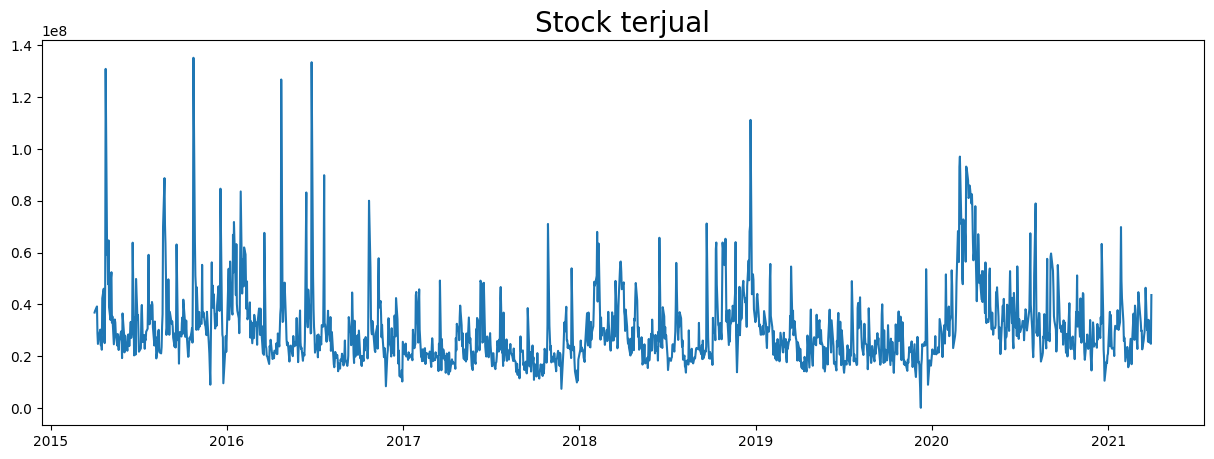

In [33]:
dates = df['Date'].values
vol = df['Volume'].values

plt.figure(figsize=(15,5))
plt.plot(dates, vol)
plt.title('Stock terjual',
          fontsize=20);

In [35]:
vol = vol.reshape(-1,1)
vol

array([[36865322],
       [37487476],
       [39223692],
       ...,
       [25227455],
       [24792012],
       [43623471]])

## Normalisasi Data

In [36]:
min_max_scaler = MinMaxScaler()
volume = min_max_scaler.fit_transform(vol)

## Inisialisasi fungsi windowed dataset

In [37]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

Melakukan split data latih dan data tes

In [49]:
date_train, date_test, vol_train, vol_test = train_test_split(dates, volume, test_size = 0.2, shuffle=False)

Memanggil fungsi windowed dataset dan membangun model dengan Sequential *model*

In [50]:
train_set = windowed_dataset(vol_train, window_size = 60, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(vol_test, window_size = 60, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(30, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.LSTM(60),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
])

Menentukan threshold mae

In [51]:
threshold_mae = (volume.max() - volume.min()) * 10/100
print(threshold_mae)

0.1


Meninisialisasi fungsi callback

In [52]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < threshold_mae):
      print("MAE kurang dari 10%, hentikan training!")
      self.model.stop_training = True
callbacks = myCallback()

Melakukan training pada model

In [53]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set,
                    epochs=100,
                    validation_data=test_set,
                    verbose=2,
                    callbacks=[callbacks])

Epoch 1/100
12/12 - 6s - loss: 0.0155 - mae: 0.1411 - val_loss: 0.0037 - val_mae: 0.0611 - 6s/epoch - 511ms/step
Epoch 2/100
MAE kurang dari 10%, hentikan training!
12/12 - 2s - loss: 0.0058 - mae: 0.0851 - val_loss: 0.0033 - val_mae: 0.0661 - 2s/epoch - 146ms/step
